# VoteMandering project notebook

This notebook implements our votemandering algorithm from our paper to find the optimal resource allocation and a target map that achieve the highest number of seats in two rounds, combined. It can be used to run large randomly generated samples with same specifications, for the purpose of reporting results with more confidence.

We use the process of Recombination to form a list of district maps within which we operate. 
We have generated the data files already, using the gerrychain package. We use this pool of maps and find our target map as the best amongst those.

We first get a list of potential target maps, then arrange those in decreasing order of
round 2 wins.
We then run our algorithm step by updating one target map entry at a time until we reach our 
optimal solution.

Inputs: (look at the input cell)
1. data files containing lists that represent map assignments (a large pool of maps).
2. budgets for both the parties
3. voter data (can be generated randomly within the code, given specifications)
4. a fairness metric bound
5. k: number of times we want to run instances of votemandering algorithm (number of samples)(instances are generated randomly given above inputs)

Output:
For each sample, the following can also be obtained through printing and/or visualization codes. (Outputs of running one instance of the votemandering algorithm)
1. Optimal target map specifications
2. optimal budget allocation 
3. Round 1 and round 2 results

This notebook can be used to compare the effects of compactness factor: two datafiles should be submitted, named datafile1 and datafile2 in the input cell.
We can also play with the budget range, alpha and the number of samples.
Outputs excel sheets showing total additional seats won for k samples, given all inputs, datafiles.


We use this code for grid graphs and a similar one for state maps.

# Installation and data generation

###   1. Optimization packages
###   2. Support codes used for data generation and some analysis

In [16]:
import networkx as nx

import pandas as pd
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
from itertools import combinations, groupby
#from IPython.core.display import HTML
import matplotlib.patches as mpatches
import gurobipy as gp
from gurobipy import GRB
import time 

start_time=time.time()


In [17]:


# Function that creates random populations V and vote shares P, Q
# if majority = True, P always corresponds to the majority party
def RandomPopulation(NumberOfUnits, minbound, maxbound, distmin, distmax, majority = True):
    if maxbound > minbound: #defining total voter population using V
      V = np.random.randint(minbound, maxbound, size=NumberOfUnits)
    else :
      V = np.repeat(maxbound, NumberOfUnits)
    #P0 = np.random.rand(NumberOfUnits) 
    P0 = np.random.uniform(distmin, distmax, NumberOfUnits) #uniformly generate vote shares
    #P0 = np.random.choice([0.4,0.6], size=NumberOfUnits)
    Q0 = 1-P0 #minority party share
    if majority == True:
      if np.sum(np.multiply(V,Q0))> np.sum(np.multiply(V,P0)):
        P0, Q0 = Q0, P0
    return V, P0, Q0

#this code can be used to create vote shares that follow some definite given pattern
def DefinedPopulation(votepattern, NumberOfUnits, minbound, maxbound, alpha, majority = True):
    if maxbound > minbound: 
      V = np.random.randint(minbound, maxbound, size=NumberOfUnits)
    else :
      V = np.repeat(maxbound, NumberOfUnits)
    P0 = []
    for i in range(0,NumberOfUnits):
        if votepattern[i]>0.5:
          P0.append(np.random.uniform(0.5, 0.7))
        else:
          P0.append(np.random.uniform(0.3, 0.5))
    P0 = np.array(P0)
    Q0 = 1-P0
    votesA = alpha*np.multiply(V,P0)
    votesB = alpha*np.multiply(V,Q0)
    return V, P0, Q0, votesA, votesB


#Uniform allocation that party B (minority) uses
def PopUniformAllocationB(NumberOfUnits, BudgetB, V, votesB):
    matrix = V
    B = matrix*BudgetB/(sum(matrix))
    NewvotesB = np.zeros(NumberOfUnits)
    for i in range(NumberOfUnits):
        NewvotesB[i] = votesB[i] + B[i]
    return NewvotesB, B
    
#Function for computing A's maximum wins using voter data and budget    
def round1max(votesA, NewvotesB, initmap, budget, NumberOfDistricts):
    cols = len(initmap)
    D=[]
    wins = 0
    for i in range(0,NumberOfDistricts):
        ind = np.where(initmap==i)
        diff = np.sum(NewvotesB[ind])- np.sum(votesA[ind])
        if diff>0:
            D.append(diff)
        else:
            wins = wins+1
    D.sort()
    B = budget
    while B>0:
        if len(D)==0:
          break
        if B > D[0]:
          B = B- D[0]
          wins = wins+1
          D.pop(0)
        else:
          B = B- D[0]
    return wins

#Sets up a dataframe that has all the processed information about maps in the list
def InitialSetup(votesA, NewvotesB, votesB, dataframe0, initmap, budget, NumberOfDistricts):
    dataframe = dataframe0
    TotalVotes = sum(votesA)+ sum(votesB)
    rows, cols = dataframe.shape
    seats = []
    s = 0
    wastedvotes = []
    for j in range(0,rows):
      v1 = dataframe.iloc[j].to_numpy()
      s=0
      W = 0 
      for i in range(0,cols):
        ind = np.where(v1==i)
        if np.sum(votesA[ind])> np.sum(votesB[ind]):
            s=s+1
            W = W + (3*np.sum(votesB[ind])-np.sum(votesA[ind]))/2
        else:
            W = W + (np.sum(votesB[ind])-3*np.sum(votesA[ind]))/2
      seats.append(s)
      wastedvotes.append(abs(W/TotalVotes))
    wins = round1max(votesA, NewvotesB, initmap, budget, NumberOfDistricts)
    dataframe['Max wins round 1']= wins #maximum wins in round 1 by party A (gets updated)
    dataframe['Wins in round 2'] = seats #wins in round 2 achieved by target maps
    
    #total wins = round 1+2, this column gets updated as we run our algorithm
    dataframe['Updated wins']= dataframe[['Max wins round 1', 'Wins in round 2']].sum(axis=1)
    dataframe['Fair?'] = 'Not yet' #this column gets updated as we run our algorithm
    dataframe['B-A Rd2 Egap'] = wastedvotes
    dataframe['FooledEgap'] = 0 #this column gets updated as we run our algorithm
    
    #sorting the list by the total number of wins, gets updated as we run our algorithm
    dataframe = dataframe.sort_values(by=['Updated wins'], ascending=False)
    
    return dataframe




## Visualization and Algorithm step

###   1. Visualization for grid graphs: 
###   2. Optimization step using gurobi

### Visualization:
First creates a grid graph instance and a label environment.
Plots multiple graphs showing all steps: the initial map, the target map, investments on both, the votemandered map with updated vote shares and both round wins


In [18]:
def gridgraph(nodesx, nodesy):
    G = nx.grid_graph([nodesy,nodesx])
    #G = nx.grid_2d_graph(nodesy,nodesx) 
    dict1= dict(zip(G.nodes, range(nodesx*nodesy)))
    neighbors = []
    for i in G.nodes:
      neighbors.append([dict1[n] for n in G.neighbors(i)])
    return neighbors, G

def createlabels(Y,G):
    labels = {}
    i=0
    for node in G.nodes:
        if Y[i]>0.5:
            labels[node]='A'
        i=i+1
    return labels

def plotgraphs(G, NumberOfUnits, NumberOfDistricts, initmap, targetmap, NewvotesA, NewvotesB, votesA, votesB):
    #my_pos={x: x for x in G.nodes()},          
    my_pos = nx.spring_layout(G, seed = 500)
    my_pos = {(x,y):(y,-x) for x,y in G.nodes()}
    figsize=(10, 10)
    pos_higher = {}
    pos_lower = {}
    x_off = 0.3 # offset on the x axis
    y_off = 0.3 # offset on the y axis
    red_patch = mpatches.Patch(color='red', label='Votes for A')
    black_patch = mpatches.Patch(color='black', label='Votes for B')
    #black_patch = mpatches.Patch(color=colors[1], label='Votes for B')
    cmap=plt.cm.Spectral

    
    for k, v in my_pos.items():
        pos_higher[k] = (v[0]+x_off, v[1]+y_off)
    
    for k, v in my_pos.items():
        pos_lower[k] = (v[0]+x_off, v[1]-y_off)

#1 Initial map with original vote shares
    votesdiff1=[]
    W0=np.zeros((NumberOfUnits, NumberOfUnits))
    for i in range(0, NumberOfDistricts): 
      ind = np.where(initmap==i)
      votesdiff1.append(round(np.sum(votesA[ind])- np.sum(NewvotesB[ind])))
      if np.sum(votesA[ind])> np.sum(votesB[ind]):
        for j in ind:
          W0[ind[0],j] = i+1
    W0 = np.sum(W0, axis=0)

    '''
    plt.figure(6, figsize=(2,2))
    cmap=plt.cm.Spectral
    for i in range(len(votesdiff1)):
        plt.scatter([],[], c= [cmap(i/NumberOfDistricts)], label='VoteDiff {}'.format(votesdiff1[i]))

    plt.legend()
    '''

    plt.figure(1, figsize=figsize)
    plt.margins(x=0.25, y=0.25)
    ax = plt.gca()
    ax.set_title('Original map and original data: given data for investing')
    #G1 = nx.draw(G, node_color = [cmap(v/NumberOfDistricts) for v in initmap],  pos = my_pos, ax=ax)
    G1 = nx.draw(G, node_color =  initmap,  pos = my_pos, ax=ax)
    labels = createlabels(W0,G) 
    nx.draw_networkx_labels(G1, my_pos, labels, font_size=20, font_color='w')
    
    labels = {}
    i=0
    for node in G.nodes:
        labels[node]= str(round(votesA[i]))
        i=i+1
    nx.draw_networkx_labels(G1,pos_higher,labels,font_size=10,font_color='r')
    
    labels = {}
    i=0
    for node in G.nodes:
        labels[node]= str(round(votesB[i]))
        i=i+1
    nx.draw_networkx_labels(G1,pos_lower,labels,font_size=10,font_color='k')
    plt.legend(handles=[red_patch, black_patch],bbox_to_anchor=(1.05, 1))
  
    
#1.5 Showing A's investment on the original map, and the vote difference after B invests

    W05=np.zeros((NumberOfUnits, NumberOfUnits))
    for i in range(0, NumberOfDistricts): 
      ind = np.where(initmap==i)
      if np.sum(votesA[ind])> np.sum(votesB[ind]):
        for j in ind:
          W05[ind[0],j] = i+1
    W05 = np.sum(W05, axis=0)

  
    plt.figure(7, figsize=figsize)
    plt.margins(x=0.25, y=0.25)
    ax = plt.gca()
    ax.set_title('Budget investment by A and the vote differences after B invests: on the original map')
    G15 = nx.draw(G, node_color = [cmap(v/NumberOfDistricts) for v in initmap],  pos = my_pos, ax=ax)
    #G15 = nx.draw(G, node_color =  initmap,  pos = my_pos, ax=ax)
    labels = createlabels(W05,G) 
    nx.draw_networkx_labels(G15, my_pos, labels, font_size=20, font_color='w')
    
    labels = {}
    i=0
    for node in G.nodes:
        labels[node]= str(round(NewvotesA[i])-round(votesA[i]))
        i=i+1
    nx.draw_networkx_labels(G15,pos_higher,labels,font_size=10,font_color='r')
    
    cmap=plt.cm.Spectral
    for i in range(len(votesdiff1)):
        plt.scatter([],[], c= [cmap(i/NumberOfDistricts)], label='VoteDiff {}'.format(votesdiff1[i]))

    plt.legend()

#2 On the original map with updated vote shares by both parties: result of round 1
    votesdiff2=[]
    W2=np.zeros((NumberOfUnits, NumberOfUnits))
    for i in range(0, NumberOfDistricts): 
      ind = np.where(initmap==i)
      votesdiff2.append(np.sum(NewvotesA[ind])- np.sum(NewvotesB[ind]))
      if np.sum(NewvotesA[ind])> np.sum(NewvotesB[ind]):
        for j in ind:
          W2[ind[0],j] = i+1
    W2 = np.sum(W2, axis=0)

    plt.figure(2, figsize=figsize)
    plt.margins(x=0.25, y=0.25)
    ax = plt.gca()
    ax.set_title('On the original map after strategic campaigning: Rd 1 result')
    G2 = nx.draw(G, node_color= initmap,  pos = my_pos, ax=ax)
    labels = createlabels(W2,G) 
    nx.draw_networkx_labels(G2,my_pos,labels,font_size=20,font_color='w')

    
    labels = {}
    i=0
    for node in G.nodes:
        labels[node]= str(round(NewvotesA[i]))
        i=i+1
    nx.draw_networkx_labels(G2,pos_higher,labels,font_size=10,font_color='r')
   
    labels = {}
    i=0
    for node in G.nodes:
        labels[node]= str(round(NewvotesB[i]))
        i=i+1
    nx.draw_networkx_labels(G2,pos_lower,labels,font_size=10,font_color='k')
    plt.legend(handles=[red_patch, black_patch],bbox_to_anchor=(1.05, 1))

#2.5  A's investment on the target map and vote difference after B invests on the target map
    votesdiff25=[]
    W25=np.zeros((NumberOfUnits, NumberOfUnits))
    for i in range(0,NumberOfDistricts):
      ind = np.where(targetmap==i)
      votesdiff25.append(round(np.sum(votesA[ind]))- round(np.sum(NewvotesB[ind])))
      if np.sum(votesA[ind])> np.sum(NewvotesB[ind]):
        for j in ind:
          W25[ind[0],j] = i+1
    W25 = np.sum(W25, axis=0)

  
    plt.figure(8, figsize=figsize)
    plt.margins(x=0.25, y=0.25)
    ax = plt.gca()
    ax.set_title('Budget investment by A and vote differnces after B invests: on target map')
    G25 = nx.draw(G, node_color = [cmap(v/NumberOfDistricts) for v in targetmap],  pos = my_pos, ax=ax)
    #G15 = nx.draw(G, node_color =  initmap,  pos = my_pos, ax=ax)
    labels = createlabels(W25,G) 
    nx.draw_networkx_labels(G25, my_pos, labels, font_size=20, font_color='w')
    
    labels = {}
    i=0
    for node in G.nodes:
        labels[node]= str(round(NewvotesA[i])-round(votesA[i]))
        i=i+1
    nx.draw_networkx_labels(G25,pos_higher,labels,font_size=10,font_color='r')
    
    cmap=plt.cm.Spectral
    for i in range(len(votesdiff1)):
        plt.scatter([],[], c= [cmap(i/NumberOfDistricts)], label='VoteDiff {}'.format(votesdiff25[i]))

    plt.legend()

#3 The votemandered map that is shown to be fair using updated vote shares
    votesdiff3=[]
    W3=np.zeros((NumberOfUnits, NumberOfUnits))
    for i in range(0,NumberOfDistricts):
      ind = np.where(targetmap==i)
      votesdiff3.append(np.sum(NewvotesA[ind])- np.sum(NewvotesB[ind]))
      if np.sum(NewvotesA[ind])> np.sum(NewvotesB[ind]):
        for j in ind:
          W3[ind[0],j] = i+1
    W3 = np.sum(W3, axis=0)

    plt.figure(3, figsize=figsize)
    plt.margins(x=0.25, y=0.25)
    ax = plt.gca()
    ax.set_title('On the target map after strategic campaigning: should be fair')
    G3 = nx.draw(G, node_color= targetmap, pos = my_pos, ax=ax)
    labels = createlabels(W3,G) 
    nx.draw_networkx_labels(G3,my_pos,labels,font_size=20,font_color='w')

    labels = {}
    i=0
    for node in G.nodes:
        labels[node]= str(round(NewvotesA[i]))
        i=i+1
    nx.draw_networkx_labels(G3,pos_higher,labels,font_size=10,font_color='r')
   
    labels = {}
    i=0
    for node in G.nodes:
        labels[node]= str(round(NewvotesB[i]))
        i=i+1
    nx.draw_networkx_labels(G3,pos_lower,labels,font_size=10,font_color='k')
    plt.legend(handles=[red_patch, black_patch],bbox_to_anchor=(1.05, 1))


#4 The final target map with original vote shares: Rd 2 results
    votesdiff4=[]
    W1=np.zeros((NumberOfUnits, NumberOfUnits))
    for i in range(0,NumberOfDistricts):
      ind = np.where(targetmap==i)
      votesdiff4.append(np.sum(votesA[ind])- np.sum(votesB[ind]))
      if np.sum(votesA[ind])> np.sum(votesB[ind]):
        for j in ind:
          W1[ind[0],j] = i+1
    W1 = np.sum(W1, axis=0)

    plt.figure(4, figsize=figsize)
    plt.margins(x=0.25, y=0.25)
    ax = plt.gca()
    ax.set_title('On the target map with original vote data: max this 2')
    G2 = nx.draw(G, node_color= targetmap, pos = my_pos, ax=ax)
    labels = createlabels(W1,G) 
    nx.draw_networkx_labels(G2,my_pos,labels,font_size=20,font_color='w')

    
    labels = {}
    i=0
    for node in G.nodes:
        labels[node]= str(round(votesA[i]))
        i=i+1
    nx.draw_networkx_labels(G2,pos_higher,labels,font_size=10,font_color='r')
    
    labels = {}
    i=0
    for node in G.nodes:
        labels[node]= str(round(votesB[i]))
        i=i+1
    nx.draw_networkx_labels(G2,pos_lower,labels,font_size=10,font_color='k')
    plt.legend(handles=[red_patch, black_patch],bbox_to_anchor=(1.05, 1))

### Algorithm: the update step
Takes a dataframe, performs a step and returns the dataframe after updating.

The step is characterized by optimizing for the round 1 wins, given that the target map should look fair with the updated data. If the round 1 wins match with the maximum possible wins,  we're done, otherwise we mark that target map ('fair' or 'infeasible') and update the column 'updated wins' and sort the list, and move on to the next step by returning the df. 

In [19]:
def MyAlgoStep(votesA, NewvotesB, df, initmap, budget, NumberOfDistricts, Egap, alpha):
    BigM = budget*1000
    TotalVotes = sum(votesA)+ sum(NewvotesB) + budget
    NoOfUnits = len(initmap)
    W=0
    v0 = df.iloc[0, 0:NoOfUnits]
    #computing the efficiency gap (wasted votes) of the target map, after B invests.
    v1 = v0.to_numpy()
    for i in range(0, NumberOfDistricts):
        ind = np.where(v1==i)
        if np.sum(votesA[ind])> np.sum(NewvotesB[ind]):
            W = W + (3*np.sum(NewvotesB[ind])-np.sum(votesA[ind]))/2
        else:
            W = W + (np.sum(NewvotesB[ind])-3*np.sum(votesA[ind]))/2
    deficit = (3/2)*budget+ Egap*TotalVotes - W
    #check the basic constraint of whether we have enough budget to bring the number of 
    # wasted votes within the allowed range. If not, mark `infeasible' and return immediately.
    if deficit < 0:
      df.iloc[0,NoOfUnits+3] = 'Infeasible'
      df.iloc[0,NoOfUnits+5] = 50
      df.iloc[0,NoOfUnits]= 0
      Total2rounds= df.iloc[0,NoOfUnits]+ df.iloc[0,NoOfUnits+1]
      df.iloc[0,NoOfUnits+2]= Total2rounds
      df = df.sort_values(by=['Updated wins'], ascending=False)
      stop = 'no'
      #print('No need to check')
      return df, stop, 0, 0, 0, 0
    else:
      #print('Need to check')
    
      # If not infeasible, we create the optimization model and find the number of rd 1 wins.

      # Creation of a Concrete Model
      model = gp.Model()
      model.Params.LogToConsole = 0

      # indexing for defining variables
      units = range(len(initmap))  #preparing a set
      districts = range(NumberOfDistricts)

      # declare decision variables
      X = model.addVars(districts,  vtype='B') #indicating round 1 wins
      Y = model.addVars(districts,  vtype='B')  #indicating round 2 wins
      T = model.addVars(districts,   vtype='C', lb= -GRB.INFINITY) #diff between wasted votes in i'th district
      b = model.addVars(units,  vtype='C', lb= 0) #budget spent in each unit 
      v = model.addVars(units,  vtype='C', lb= 0) #Newvotes for A in each unit 
      
    
      #Objective function
      totalseats = model.setObjective( 
          expr = sum(X[i] for i in districts), sense=gp.GRB.MAXIMIZE)

      #building variables that we need in the constraints
      targetmap = df.iloc[0].to_numpy()
      targetmap = targetmap[0:NumberOfUnits]
      setI = []
      for i in range(0,NumberOfDistricts):
          ind = np.where(initmap==i)
          setI.append(ind[0])


      setJ = []
      for i in range(0,NumberOfDistricts):
          ind = np.where(targetmap==i)
          setJ.append(ind[0])

      #Constraints : budget constraints
      
      for i in units:
          model.addConstr(
          votesA[i]+b[i] == v[i], name="budgetconstraints")
    
      for i in units:
          model.addConstr(
          b[i] <=  votesA[i]*(1-alpha), name="budgetconstraints2")
          
      model.addConstr(sum(b[i] for i in units) <= budget,  name="totalbudgetconstraint")
          
      #Constraints : Round 1 constraints
      
      
      for i in districts:
          model.addConstr(
          sum(v[k] for k in setI[i])- sum(NewvotesB[k] for k in setI[i])>=
          1 - BigM*(1-X[i]), name="Rd1constraints1")

         
      for i in districts:
          model.addConstr(
          sum(v[k] for k in setI[i])- sum(NewvotesB[k] for k in setI[i])<=
            BigM*(X[i]), name="Rd1constraints2")
      
      #Constraints : Round 2 constraints
      
      for i in districts:
          model.addConstr(
          sum(v[k] for k in setJ[i])- sum(NewvotesB[k] for k in setJ[i])>=
          1 - BigM*(1-Y[i]), name="Rd2constraints1")

      
      for i in districts:
          model.addConstr( sum(v[k] for k in setJ[i])- 
                          sum(NewvotesB[k] for k in setJ[i])<= BigM*(Y[i]), name="Rd2constraints2")

      #Constraints : Round 2 wasted votes
      
      for i in districts:
          model.addConstr( - T[i] + (3*sum(NewvotesB[k] for k in setJ[i])- 
          sum(v[k] for k in setJ[i]))/2 <= BigM*(1-Y[i]), name="Tconstraints1")
 
      
      for i in districts:
          model.addConstr(- T[i] + (3*sum(NewvotesB[k] for k in setJ[i])- 
          sum(v[k] for k in setJ[i]))/2 >= 0, name="Tconstraints2")
      
      
      for i in districts:
          model.addConstr(T[i] - (sum(NewvotesB[k] for k in setJ[i])- 
          3*sum(v[k] for k in setJ[i]))/2 <= BigM*(Y[i]), name="Tconstraints3")

      
      for i in districts:
          model.addConstr( T[i] - (sum(NewvotesB[k] for k in setJ[i])- 
          3*sum(v[k] for k in setJ[i]))/2 >= 0, name="Tconstraints4")
      
      
      model.addConstr((sum(T[i] for i in districts))/TotalVotes <= Egap,name="Egapcon") 
      #model.addConstr((sum(T[i] for i in districts))/TotalVotes >= -Egap) 
      model.update()

      #Solution 
    
      model.optimize()
      '''
      model.computeIIS()
      model.write("model.ilp")
      if model.status == GRB.INFEASIBLE:
        model.feasRelaxS(1, False, False , True)
        model.optimize()
      '''
      
      WastedVotes = []
      if model.status == GRB.INFEASIBLE:
          total = 0
          df.iloc[0,NoOfUnits+3] = 'Infeasible'
      else:
          total = 0
          df.iloc[0,NoOfUnits+3] = 'Yes'
          for i in range(NumberOfDistricts):
            total = total + X[i].getAttr(GRB.Attr.X)
            WastedVotes.append(T[i].getAttr(GRB.Attr.X))
      
      if model.status == GRB.INFEASIBLE:
          EgapTotal = 50
          df.iloc[0,NoOfUnits+5] = EgapTotal
      else:    
          EgapTotal = sum(WastedVotes)/TotalVotes
          df.iloc[0,NoOfUnits+5] = EgapTotal 
      
    
      df.iloc[0,NoOfUnits]= total
      Total2rounds= df.iloc[0,NoOfUnits]+ df.iloc[0,NoOfUnits+1]
      df.iloc[0,NoOfUnits+2]= Total2rounds
      df = df.sort_values(by=['Updated wins'], ascending=False)
      
      if df.iloc[0,NoOfUnits+2] > Total2rounds:
        stop = 'no'
      else: 
        #stop = 'no'
        stop = 'yes'

      BudgetAlloc = []
      NewvotesA = []
        
      if model.status == GRB.INFEASIBLE:
          return df, stop, BudgetAlloc, NewvotesA, WastedVotes, EgapTotal
      else:
        for i in range(NoOfUnits):
            bs = b[i].getAttr(GRB.Attr.X)
            vs = v[i].getAttr(GRB.Attr.X)
            BudgetAlloc.append(bs)
            NewvotesA.append(vs)
        return df, stop, BudgetAlloc, NewvotesA, WastedVotes, EgapTotal

# Functions

### Command: 
The first function in line that gets the initial setup done, and runs the algosteps until convergence, giving the allocation and completely updated dataframe. 
### Analysis:
Uses the dataframe further and gets all the important values for the optimal solution.
### Doeverything: 
The main function that takes the data from file, calls command and analysis and outputs everything that we need for the optimal solution, along with the updated dataframe.

In [20]:
def command(votesA, NewvotesB, votesB, df0, initmap, budgetA, Egap, alpha, maxiter):
    NumberOfDistricts = int(max(initmap)+1)
    NumberOfUnits = len(initmap)
    df0 = df0.sample(frac=1)
    df0 = df0[:maxiter]
   
    df = InitialSetup(votesA, NewvotesB, votesB, df0, initmap, budgetA, NumberOfDistricts)
    
    stop = 'no'
    iter = 0
    while stop == 'no':
        df, stop, BudgetAlloc, NewvotesA, wastedvotes, EgapTotal = MyAlgoStep(votesA, NewvotesB, df, initmap, budgetA, NumberOfDistricts, Egap, alpha)
        iter = iter+1
        if iter > maxiter-1:
          print('All are infeasible')
          break

    targetmap = df.iloc[0].to_numpy()
    EgapRd2 = df.iloc[0,NumberOfUnits+4]

    return  targetmap, df, BudgetAlloc, NewvotesA, EgapRd2, EgapTotal


def analysis(sr1, df, BudgetAlloc, NewvotesA, NumberOfDistricts):
    #print(df['Fair?'].value_counts()) 
    #Newvotes = BudgetAlloc+votesA
    NewvotesA =  [round(x,3) for x in NewvotesA]
    NewvotesA = np.array( NewvotesA )
    BudgetAlloc =  [round(x,3) for x in BudgetAlloc]
    #print(EgapRd2) #of the target map using updated vote shares
    target = df.iloc[0].to_numpy()
    targetmap = target[0:NumberOfUnits]
    Max = NumberOfDistricts*2
    MaxNOstrat = sr1*2
    MaxStrat = df.iloc[0,NumberOfUnits+2]
    rd1wins=  df.iloc[0,NumberOfUnits]
    rd2wins=  df.iloc[0,NumberOfUnits+1]
    targetmapnumber = df.index[0]
    #print('Maximum possible wins in 2 rounds:', Max)
    #print('Wins without strategic campaigning:', MaxNOstrat)
    #print('Wins with strategic campaigning:', MaxStrat)
    #print(df[:5])
    return targetmap, BudgetAlloc, NewvotesA, Max, MaxNOstrat, MaxStrat, rd1wins, rd2wins, targetmapnumber


def Doeverything(datafile, initmapnumber, V, votesA, votesB, Egap, budgetA, budgetB, alpha, maxiter):
    df0 = pd.read_csv(datafile, index_col=False, header=None)
    
    
    initmap = df0.iloc[initmapnumber]
    
    NumberOfDistricts = int(max(initmap)+1)
    NumberOfUnits = int(len(initmap))
    
    sr1=0 #number of seats in round 1 without strategic campaign
    for i in range(0,NumberOfDistricts):
      ind = np.where(initmap==i)
      if np.sum(votesA[ind])> np.sum(votesB[ind]):
          sr1=sr1+1


    NewvotesB, B = PopUniformAllocationB(NumberOfUnits, budgetB, V, votesB)

    targetmap, dfupdated, BudgetAlloc, NewvotesA, EgapRd2, EgapTotal = command(votesA, NewvotesB, votesB, df0, initmap, budgetA, Egap, alpha, maxiter)
    targetmap, BudgetAlloc, NewvotesA, Max, MaxNOstrat, MaxStrat, rd1wins, rd2wins, targetmapnumber = analysis(sr1, dfupdated, BudgetAlloc, NewvotesA, NumberOfDistricts)
    Fairseries = dfupdated['Fair?'].value_counts()
    
    if len(Fairseries)<3:
      InfNumber = 0
      YesNumber = Fairseries[1]
    else: 
      InfNumber = Fairseries[1]
      YesNumber = Fairseries[2]
    #print(BudgetAlloc)
    return EgapTotal, initmap, dfupdated, targetmap, Max, MaxNOstrat, MaxStrat, rd1wins, rd2wins, EgapRd2, InfNumber, YesNumber, targetmapnumber, NewvotesA, NewvotesB
#print(sum(votesA), sum(votesB))



# Experiments
Using all the functions created above, we can now run our experiments using the codes below.

1. Input file

2. Running for standard and more compact datafiles, printing the solutions, graphs and giving the final output in excel files.

### Input cell
The votemandering algorithm runs k * size(budgetrange) * size(alphaset) times for each datafile.
The notebook generates k initial maps that are fair, and runs the algorithm for each value of budget and alpha, outputting the important results in excelsheet. 

Visualization is done for the last value of k, budget or alpha, in case multiple instances are run. 

In [21]:
k = 1 # Number of data points (initial maps) we want in our simulation, for given data in this cell.
# These are generated randomly, larger the better.


datafile1 = '10_10_5.txt' #for standard maps with lower compactness scores
datafile2 = '10_10_5.txt' #for more compact maps


Egap = 0.20 #the bound we want to impose for fairenss
nodesx = 10 # for grid graphs: used in visualization as well
nodesy = 10 # for grid graphs
NumberOfUnits = nodesx*nodesy #total number of units
NumberOfDistricts = 5 #Number of districts we want

minbound, maxbound = 50, 50 #Population bounds for each unit, sampled uniformly
distmin, distmax = 0.3, 0.7 #Vote share fraction bounds for each unit, for party A, sampled uniformly
maxiter = 10 #Number of maps we want to have in our pool, used by the algorithm

budgetB = 0 #Party B's budget, spent uniformly 
#Can also be made to match with A's. This edit can be made in the next cell.

budgetrange = [  300, 500] #A's budget range


alphaset = [ 0.5, 0.6] #Alpha: the baseline voter turnout factor. 

V, P0, Q0 = RandomPopulation(NumberOfUnits, minbound, maxbound,distmin, distmax,  majority = True)

votesAoriginal = np.multiply(V,P0)
votesBoriginal = np.multiply(V,Q0)

#print(votesAoriginal, votesBoriginal)
VSA = sum(votesAoriginal)/(sum(votesAoriginal)+sum(votesBoriginal))
print('Voteshare A:', VSA)
print('Voteshare B:', 1-VSA)

Voteshare A: 0.5042778856606787
Voteshare B: 0.49572211433932134


### Running the codes for the standard file (with lower compactness score)
Creates boxplots for k samples, for the last value of alpha, showing budget vs the number of additional seats won through the budget. 
The number of additional seats for the ranges of alpha/budget/samples are also obtained through excel sheets.

We can also visualize a particular optimal solution for a particular value of budget and alpha and for a particular initial map (fix k=1, and budget and alpha as constants and run.)

In [22]:
datafile = datafile1
df0 = pd.read_csv(datafile, index_col=False, header=None)


d = {i:[] for i in alphaset}

for alpha in alphaset:
    boxlistSeats1 = []
    boxlistInfeasibles1=[]
    votesA = alpha*votesAoriginal
    votesB = alpha*votesBoriginal

    TotalVotes = sum(votesA)+ sum(votesB)
    rows, cols = df0.shape
    
    Numrange = [] #10396
    
    while len(Numrange)<k:
      initmapnumber = random.randint(0,10000)
      v1 = df0.iloc[initmapnumber].to_numpy()
      W = 0 
      
      for i in range(0,cols):
        ind = np.where(v1==i)
        if np.sum(votesA[ind]) > np.sum(votesB[ind]):

          W = W+ (3*np.sum(votesB[ind])-np.sum(votesA[ind]))/2
        else:
          W = W + (np.sum(votesB[ind])-3*np.sum(votesA[ind]))/2
        


      EgapCurrent=(W/TotalVotes)
      if abs(EgapCurrent) < Egap:
        Numrange.append(initmapnumber)
        
    #print(EgapCurrent, 'initial map egap')
    i=0
    print(k, ' maps generated for alpha = ', alpha)

    
    for budgetA in budgetrange:

      #budgetB=budgetA
      difflist=[]
      InfList = []
      Targetrange =[]
      for num in Numrange:
        initmapnumber = num 
        EgapTotal, initmap, dfupdated, targetmap, Max, MaxNOstrat, MaxStrat, rd1wins, rd2wins, EgapRd2, InfNumber, YesNumber, targetmapnumber, NewvotesA, NewvotesB = Doeverything(datafile, initmapnumber, V, votesA, votesB, Egap, budgetA, budgetB, alpha, maxiter)
        difflist.append(MaxStrat-MaxNOstrat)
        #difflist.append(MaxStrat)
        InfList.append(InfNumber)
        Targetrange.append(targetmapnumber)
      i=i+1
      boxlistSeats1.append(difflist)
      boxlistInfeasibles1.append(InfList)
    d[alpha] = boxlistSeats1
    


1  maps generated for alpha =  0.5
1  maps generated for alpha =  0.6


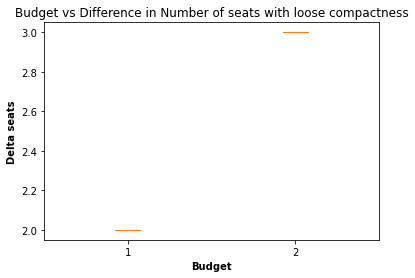

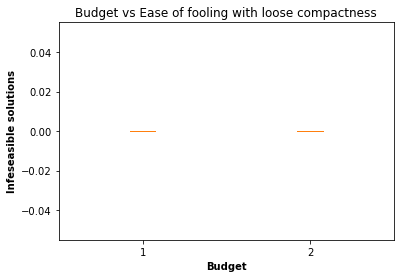

[[4], [4]]
[[2], [3]]


In [23]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.set_title('Budget vs Difference in Number of seats with loose compactness')

ax1.set_xlabel('Budget', 
               fontweight ='bold')

ax1.set_ylabel('Delta seats', 
               fontweight ='bold')

bp = ax1.boxplot(boxlistSeats1)
fig1.savefig('myboxplot1.png')
plt.show()
#print(boxlistSeats1)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)

ax3.set_title('Budget vs Ease of fooling with loose compactness')

ax3.set_xlabel('Budget', 
               fontweight ='bold')

ax3.set_ylabel('Infeseasible solutions', 
               fontweight ='bold')
bp = ax3.boxplot(boxlistInfeasibles1)
fig3.savefig('myboxplot3.png')
plt.show()
#print(boxlistInfeasibles1)

for alpha in alphaset:
    print(d[alpha])

In [24]:
dfoo = pd.DataFrame(d[alphaset[0]])
dfoo.to_excel("output.xlsx",
         sheet_name='Alpha = %s' % alphaset[0]) 
for alpha in alphaset:
  if alpha != alphaset[0]:
    dfoo = pd.DataFrame(d[alpha])
    with pd.ExcelWriter("output.xlsx", engine="openpyxl", mode="a") as writer: 
        dfoo.to_excel(writer, sheet_name='Alpha = %s' % alpha)
VotesOriginal = [votesAoriginal, votesBoriginal]
maps = [Numrange, Targetrange]
dfoo =  pd.DataFrame(VotesOriginal)
with pd.ExcelWriter("output.xlsx", engine="openpyxl", mode="a") as writer: 
        dfoo.to_excel(writer, sheet_name='VoteShares')
dfoo =  pd.DataFrame(maps)
with pd.ExcelWriter("output.xlsx", engine="openpyxl", mode="a") as writer: 
        dfoo.to_excel(writer, sheet_name='MapsInfo_ %s' % alpha)


### Calling the visualization code.
For visualization through grid graphs. Completely shows how the budget is invested, what the target map is and how the seats are won through votemandering.

Wins without any strategy =  6 Optimal total wins =  9 Round 1: 5 Round 2:  4
budget invested =  298.97034301796475


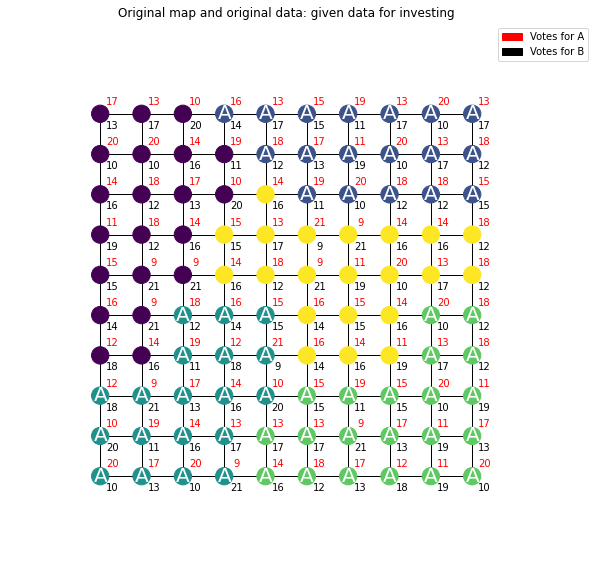

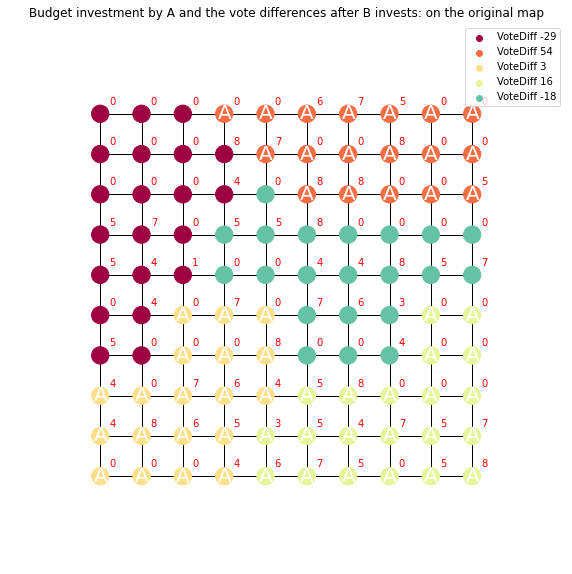

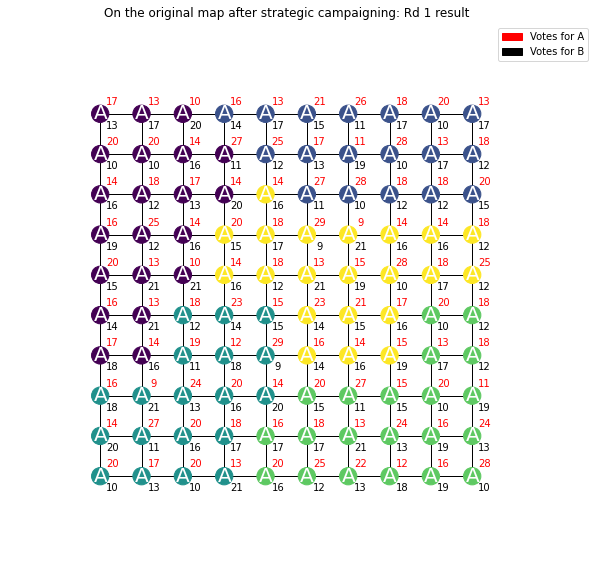

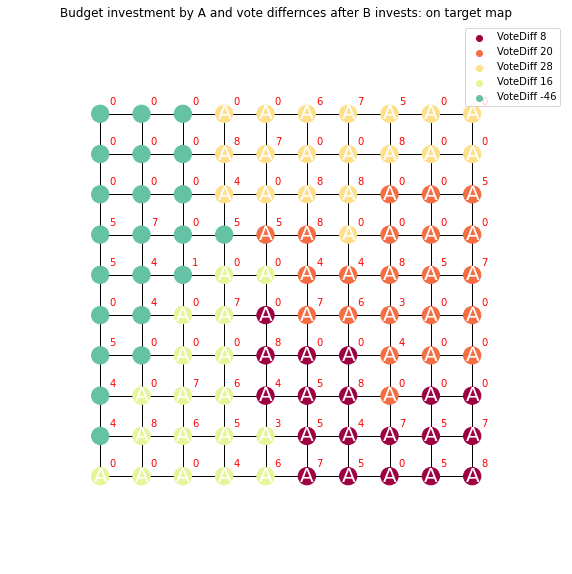

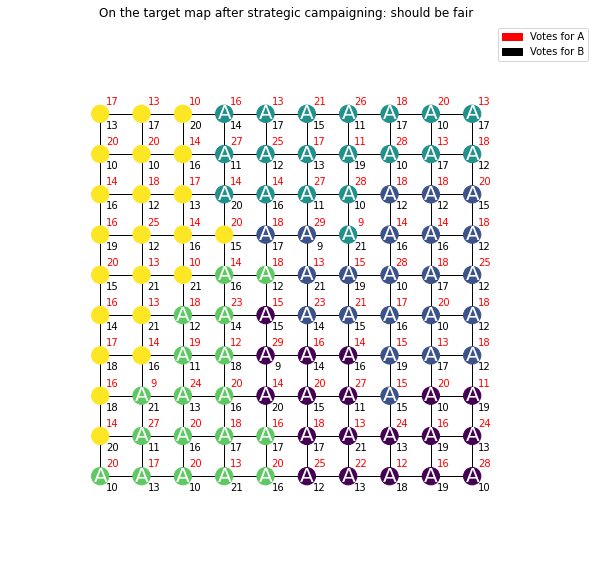

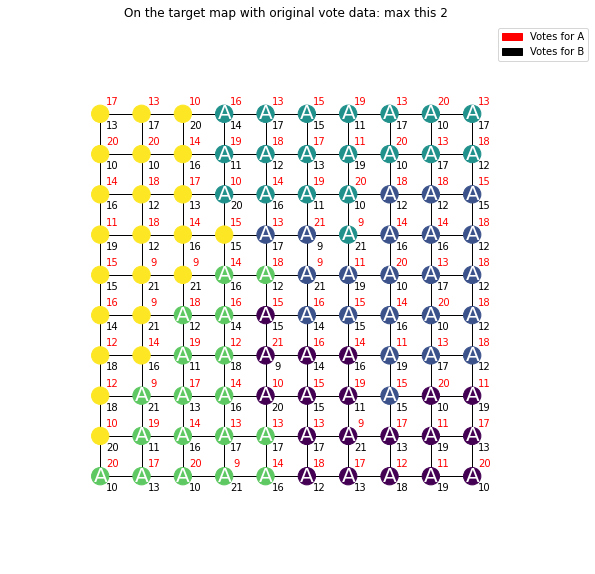

In [25]:

print('Wins without any strategy = ', MaxNOstrat, 'Optimal total wins = ', MaxStrat, 'Round 1:', rd1wins, 'Round 2: ', rd2wins)
print('budget invested = ', sum(NewvotesA)-sum(votesA))
N, G = gridgraph(nodesx,nodesy)
plotgraphs(G, NumberOfUnits, NumberOfDistricts, initmap, targetmap, NewvotesA, NewvotesB, votesA, votesB)


### For more compact datafile

Everything else is similar to the standard datafile

In [26]:
datafile = datafile2

df0 = pd.read_csv(datafile, index_col=False, header=None)

d2 = {i:[] for i in alphaset}

for alpha in alphaset:

    boxlistSeats2 = []
    boxlistInfeasibles2=[]
    votesA = alpha*votesAoriginal
    votesB = alpha*votesBoriginal

    TotalVotes = sum(votesA)+ sum(votesB)
    rows, cols = df0.shape

    Numrange2 = []
    while len(Numrange2)<k:
      initmapnumber = random.randint(0,10000)
      v1 = df0.iloc[initmapnumber].to_numpy()
      W = 0 
      for i in range(0,cols):
        ind = np.where(v1==i)
        if np.sum(votesA[ind])> np.sum(votesB[ind]):

          W = W+ (3*np.sum(votesB[ind])-np.sum(votesA[ind]))/2
        else:
          W = W + (np.sum(votesB[ind])-3*np.sum(votesA[ind]))/2

      EgapCurrent=(W/TotalVotes)
      if abs(EgapCurrent) < Egap:
        Numrange2.append(initmapnumber)

    i=0
    print(k, ' maps generated for alpha = ', alpha)

    
    for budgetA in budgetrange:
      #budgetB=budgetA
      difflist=[]
      InfList = []
      Targetrange2 = []
      for num in Numrange2: 
        initmapnumber = num
        EgapTotal, initmap, dfupdated, targetmap, Max, MaxNOstrat, MaxStrat, rd1wins, rd2wins, EgapRd2, InfNumber, YesNumber, targetmapnumber, NewvotesA, NewvotesB = Doeverything(datafile, initmapnumber, V, votesA, votesB, Egap, budgetA, budgetB, alpha, maxiter)
        difflist.append(MaxStrat-MaxNOstrat)
        #difflist.append(MaxStrat)
        InfList.append(InfNumber)
        Targetrange2.append(targetmapnumber)
      i=i+1
      boxlistSeats2.append(difflist)
      boxlistInfeasibles2.append(InfList)
    d2[alpha] = boxlistSeats2


1  maps generated for alpha =  0.5
1  maps generated for alpha =  0.6


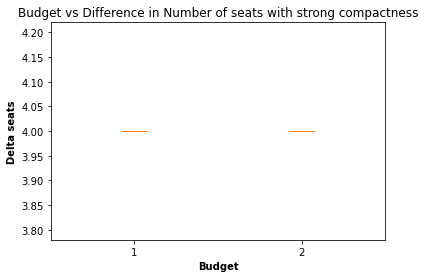

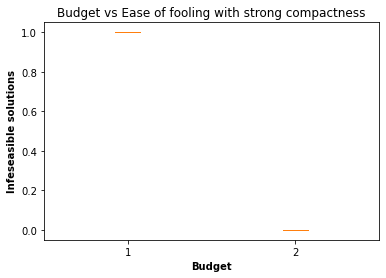

[[2], [3]]
[[4], [4]]


In [27]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

ax2.set_title('Budget vs Difference in Number of seats with strong compactness')

ax2.set_xlabel('Budget', 
               fontweight ='bold')

ax2.set_ylabel('Delta seats', 
               fontweight ='bold')

bp = ax2.boxplot(boxlistSeats2)
fig2.savefig('myboxplot2.png')
plt.show()
#print(boxlistSeats2)

fig4 = plt.figure()
ax4 = fig4.add_subplot(111)

ax4.set_title('Budget vs Ease of fooling with strong compactness')

ax4.set_xlabel('Budget', 
               fontweight ='bold')

ax4.set_ylabel('Infeseasible solutions', 
               fontweight ='bold')
bp = ax4.boxplot(boxlistInfeasibles2)
fig4.savefig('myboxplot4.png')
plt.show()
#print(boxlistInfeasibles2)

for alpha in alphaset:
    print(d2[alpha])

In [28]:
dfoo = pd.DataFrame(d2[alphaset[0]])
dfoo.to_excel("outputcmpt.xlsx",
             sheet_name='Sheet_name_%s' % alphaset[0]) 
for alpha in alphaset:
    if alpha != alphaset[0]:
        dfoo = pd.DataFrame(d2[alpha])
        with pd.ExcelWriter("outputcmpt.xlsx", engine="openpyxl", mode="a") as writer: 
            dfoo.to_excel(writer, sheet_name='Sheet_name_%s' % alpha)
VotesOriginal = [votesAoriginal, votesBoriginal, V]
dfoo = pd.DataFrame(VotesOriginal)
with pd.ExcelWriter("outputcmpt.xlsx", engine="openpyxl", mode="a") as writer: 
        dfoo.to_excel(writer, sheet_name='VoteShares')
maps = [Numrange2, Targetrange2]
dfoo =  pd.DataFrame(maps)
with pd.ExcelWriter("outputcmpt.xlsx", engine="openpyxl", mode="a") as writer: 
        dfoo.to_excel(writer, sheet_name='MapsInfo_ %s' % alpha)


In [29]:
end_time = time.time()
print("Total_time = ", end_time-start_time, " seconds")

Total_time =  12.753901958465576  seconds


In [30]:
'''
VotesOriginal = [votesAoriginal, votesBoriginal, V]
dfoo = pd.DataFrame(VotesOriginal)
dfoo.to_excel("outputmyexmaple.xlsx",
             sheet_name='VoteShares' )
'''

'\nVotesOriginal = [votesAoriginal, votesBoriginal, V]\ndfoo = pd.DataFrame(VotesOriginal)\ndfoo.to_excel("outputmyexmaple.xlsx",\n             sheet_name=\'VoteShares\' )\n'